# Sleep scoring

Load packages

In [1]:
import quantities as pq
import numpy as np
import neo
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
import scipy
from scipy import interpolate
from scipy import fftpack
from scipy import signal
from scipy import stats
from ipywidgets import interactive, widgets
%matplotlib widget

from ephyviewer import mkQApp, MainViewer, TraceViewer

Load downsampled recordings

In [3]:
folder_base = Path('C:/Users/AudreyHay/Desktop/openephys/2024-02-28_09-41-48/Record_Node_103/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/')

filename0 = folder_base / f'LFPwake0.npy'
filename2 = folder_base / f'RawDataChannelExtractedDS.npy'
filenamePKL = folder_base / f'EMGframeBoolean.pkl'

All = np.load(filename2, mmap_mode= 'r')
All0 = np.load(filename0, mmap_mode= 'r')
Bool = pd.read_pickle(filenamePKL)
All = All

Associate channels to brain areas

In [9]:
EMG = All[:, 21]#GL 11
PFC1 = All[:, 0]#GL 22
PFC2 = All[:, 2]#GL 23
PFC = PFC2 #- PFC1
S11 = All[:, 10]#GL 18
S12 = All[:, 11]#GL 19
S1 = S11 #- S11
CA11 = All0[:, 1]#GL 13
CA12 = All0[:, 1]#GL 15
CA13 = All[:, 2]
CA1 = CA12# - CA11

ThetaCh = CA1
Beta1Ch = PFC
Beta2Ch = S1
EMG.shape



(21658624,)

Visualise to determine what channel/stereochannel to use to extract muscular activity, delta, theta, beta and maybe index of higher frequency

In [4]:
start = 000000
end = len(EMG)
EMGs = EMG[start:end, np.newaxis]
PFC1s = PFC1[start:end, np.newaxis]
PFC2s = PFC2[start:end, np.newaxis]
PFCs = PFC[start:end, np.newaxis]
S11s = S11[start:end, np.newaxis]
S12s = S12[start:end, np.newaxis]
S1s = S1[start:end, np.newaxis]
CA11s = CA11[start:end, np.newaxis]
CA12s = CA12[start:end, np.newaxis]
CA1s = CA1[start:end, np.newaxis]
combined = np.append(EMGs, PFC1s, axis=1)
combined = np.append(combined, PFC2s, axis=1)
combined = np.append(combined, PFCs, axis=1)
combined = np.append(combined, S12s, axis=1)
combined = np.append(combined, S11s, axis=1)
combined = np.append(combined, S1s, axis=1)
combined = np.append(combined, CA11s, axis=1)
combined = np.append(combined, CA12s, axis=1)
combined = np.append(combined, CA1s, axis=1)

In [5]:
app = mkQApp()


sample_rate = 1000.
t_start = 1.

#Create the main window that can contain several viewers
win = MainViewer()
view1 = TraceViewer.from_numpy(combined, sample_rate, t_start, 'Signals')
win.add_view(view1)

#Parameters can be set in script
#view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True
#And also parameters for each channel
view1.by_channel_params['ch0', 'color'] = '#aa0000'
view1.by_channel_params['ch1', 'color'] = '#0055ff'
view1.by_channel_params['ch2', 'color'] = '#0055ff'
view1.by_channel_params['ch4', 'color'] = '#ff5500'
view1.by_channel_params['ch5', 'color'] = '#ff5500'
view1.by_channel_params['ch7', 'color'] = '#9b3b70'
view1.by_channel_params['ch8', 'color'] = '#9b3b70'
#view1.by_channel_params['ch9', 'color'] = '#9b3b70'



view1.by_channel_params['ch0', 'gain'] = 0.00002
view1.by_channel_params['ch1', 'gain'] = 0.00002
view1.by_channel_params['ch2', 'gain'] = 0.00002
view1.by_channel_params['ch3', 'gain'] = 0.00006
view1.by_channel_params['ch4', 'gain'] = 0.00002
view1.by_channel_params['ch5', 'gain'] = 0.00002
view1.by_channel_params['ch6', 'gain'] = 0.00003
view1.by_channel_params['ch7', 'gain'] = 0.00002
view1.by_channel_params['ch8', 'gain'] = 0.00002
view1.by_channel_params['ch9', 'gain'] = 0.00002

view1.by_channel_params['ch0', 'offset'] = 0.5
view1.by_channel_params['ch1', 'offset'] = 0.4
view1.by_channel_params['ch2', 'offset'] = 0.3
view1.by_channel_params['ch3', 'offset'] = 0.2
view1.by_channel_params['ch4', 'offset'] = 0.1
view1.by_channel_params['ch5', 'offset'] = 0
view1.by_channel_params['ch6', 'offset'] = -0.1
view1.by_channel_params['ch7', 'offset'] = -0.2
view1.by_channel_params['ch8', 'offset'] = -0.3
view1.by_channel_params['ch9', 'offset'] = -0.4

#Run
win.show()
app.exec_()

0

## Build vigilance state scoring vector
[we use here liberal boolean for wake detection]

    ### 0 = wake
    ### 1 = REM
    ### >1 = NREM

    

Set all sleep at 1 and wake at 0

In [6]:
ScoringVectorLength = len(EMG)
ScoringVector = np.zeros((ScoringVectorLength))
WakeStatus = np.zeros((ScoringVectorLength))
EMGStatusBoolLib = Bool.BooleanLiberal
print(len(EMGStatusBoolLib)) 
print(len(WakeStatus))
print(EMGStatusBoolLib)
print (WakeStatus)
indices_to_update = np.where(EMGStatusBoolLib)[0]
valid_indices = indices_to_update[indices_to_update < len(WakeStatus)]
WakeStatus[valid_indices] = 1







21658624
21658624
0           False
1           False
2           False
3           False
4           False
            ...  
21658619     True
21658620     True
21658621     True
21658622     True
21658623     True
Name: BooleanLiberal, Length: 21658624, dtype: bool
[0. 0. 0. ... 0. 0. 0.]


Extract REM and set NREM at 2

In [7]:
# Filtre parameter:
f_lowcut = 5.
f_hicut = 9.
fs = 1000
nyq = 0.5 * fs
N = 4                 # Filtre order
Wn = [f_lowcut/nyq,f_hicut/nyq]  # Nyquist frequency fraction

# Filtering:
b, a = signal.butter(N, Wn, 'band')
filt_Theta = signal.filtfilt(b, a, ThetaCh)

# Parameter and computation of CWT
w = 30.
freq = np.linspace(5, 9, 8)
widths = w*fs / (2*freq*np.pi)
ThetaCWT = signal.cwt(filt_Theta, signal.morlet2, widths, w=w)

# Projection calculation
absThetaCWT = np.absolute(ThetaCWT)
from scipy import stats

zabsThetaCWT = stats.zscore(absThetaCWT, axis=None)

proj_ThetaCWT = np.max(zabsThetaCWT, axis = 0)/8
sdproj_ThetaCWT = np.std(proj_ThetaCWT)
meanproj_ThetaCWT = np.mean(proj_ThetaCWT)

numpnts = EMG.size
ThetaStatus = np.zeros(numpnts)
for ind in range(numpnts):
    if proj_ThetaCWT[ind]>(meanproj_ThetaCWT+1.4*sdproj_ThetaCWT):
        ThetaStatus[ind] = 1 


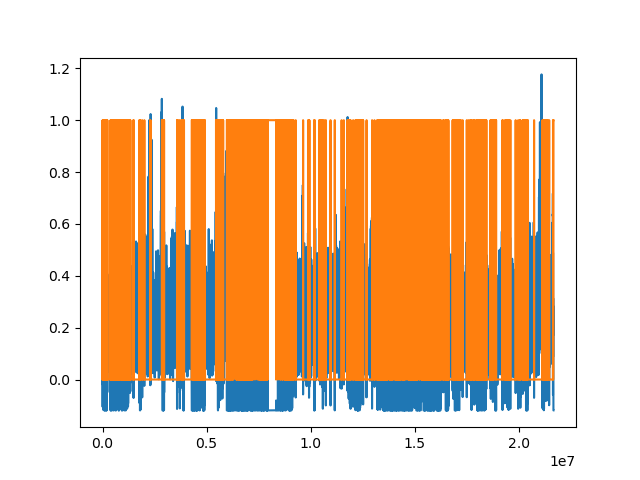

In [8]:
plt.close()
plt.plot(proj_ThetaCWT)
plt.plot(WakeStatus)

plt.show()

Extract beta 

In [9]:
# Filtre parameter: paramètres de filtrage non optimal ?
f_lowcut = 10.
f_hicut = 18.
fs = 1000
nyq = 0.5 * fs
N = 4                # Filtre order
Wn = [f_lowcut/nyq,f_hicut/nyq]  # Nyquist frequency fraction

# Filtering:
b, a = signal.butter(N, Wn, 'band')
filt_Beta1 = signal.filtfilt(b, a, Beta1Ch)
filt_Beta2 = signal.filtfilt(b, a, Beta2Ch)

# Parameter and computation of CWT : non adaptées ?
w = 10
freq = np.linspace(10, 18, 16)
widths = w*fs / (2*freq*np.pi)
Beta1CWT = signal.cwt(filt_Beta1, signal.morlet2, widths, w=w)
Beta2CWT = signal.cwt(filt_Beta2, signal.morlet2, widths, w=w)

# Projection calculation : seuils choisis ne conviendrait pas aux données ?
absBeta1CWT = np.absolute(Beta1CWT)
absBeta2CWT = np.absolute(Beta2CWT)
from scipy import stats

zabsBeta1CWT = stats.zscore(absBeta1CWT, axis=None)
zabsBeta2CWT = stats.zscore(absBeta2CWT, axis=None)

proj_Beta1CWT = np.max(zabsBeta1CWT, axis = 0)/16
proj_Beta2CWT = np.max(zabsBeta2CWT, axis = 0)/16
meanproj_Beta1CWT = np.mean(zabsBeta1CWT)
meanproj_Beta2CWT = np.mean(zabsBeta2CWT)
sdproj_Beta1CWT = np.std(proj_Beta1CWT)
sdproj_Beta2CWT = np.std(proj_Beta2CWT)

numpnts = EMG.size
Beta1Status = np.zeros(numpnts)
Beta2Status = np.zeros(numpnts)
for ind in range(numpnts):
    if proj_Beta1CWT[ind]>(meanproj_Beta1CWT+3*sdproj_Beta1CWT):
        Beta1Status[ind] = 1
    if proj_Beta2CWT[ind]>(meanproj_Beta2CWT+3*sdproj_Beta2CWT):
        Beta2Status[ind] = 1


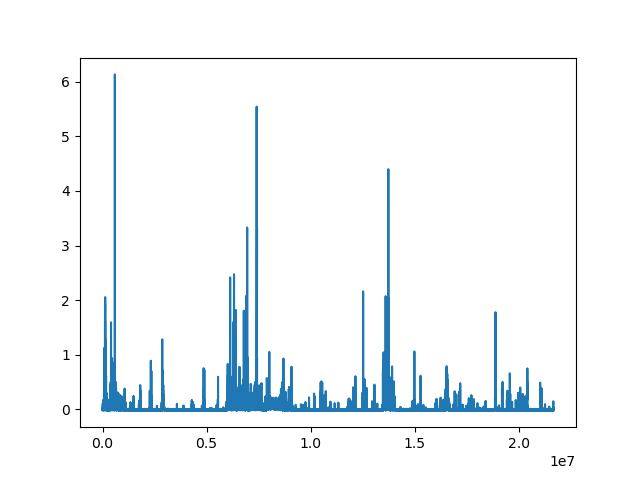

No such comm: 7a605d558f904e02a6a5a64c5d9fbe82


In [10]:
plt.close()
plt.plot(proj_Beta2CWT)
plt.show()

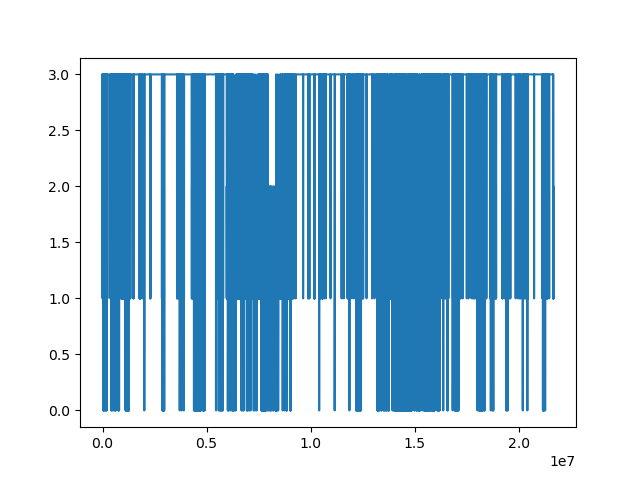

In [12]:
ScoringVector = np.ones((ScoringVectorLength))
for ind in range(numpnts):
    if ThetaStatus[ind]>0:
        ScoringVector[ind] = 2
    if Beta1Status[ind]>0:
        ScoringVector[ind] = 0
    if WakeStatus[ind]==0:
        ScoringVector[ind] = 3

plt.close()
plt.plot(ScoringVector)
plt.show()

Reduce bins

In [14]:
input_arr = ThetaStatus

R = round(ScoringVectorLength/5000) # 5 sec bins

split_arr = np.linspace(0, len(input_arr), num=R+1, dtype=int)

dwnsmpl_subarr = np.split(input_arr, split_arr[1:])

dwnsmpl_arrT = np.array( list( np.mean(item) for item in dwnsmpl_subarr[:-1] ) )

for i in range(len(dwnsmpl_arrT)):
    if dwnsmpl_arrT[i]<0.25:
        dwnsmpl_arrT[i] = 0
    else:
        dwnsmpl_arrT[i] = 1  

for i in range(len(dwnsmpl_arrT)-3):
    if i > (len(dwnsmpl_arrT)-3):
        print(i)
        break          
    elif (dwnsmpl_arrT[i]>0 and dwnsmpl_arrT[i+2]>0):
        dwnsmpl_arrT[i+1]=1
    elif (dwnsmpl_arrT[i]>0 and dwnsmpl_arrT[i+3]>0):
        dwnsmpl_arrT[i+1]=1
        dwnsmpl_arrT[i+2]=1

for i in range(len(dwnsmpl_arrT)):
    if i > (len(dwnsmpl_arrT)-3):
        print(i)
        break
    elif (dwnsmpl_arrT[i]<1 and dwnsmpl_arrT[i+1]>0 and dwnsmpl_arrT[i+2]<1):
        dwnsmpl_arrT[i+1]=0


4330


In [21]:
input_arr1 = proj_Beta1CWT
input_arr2 = proj_Beta2CWT

R = round(ScoringVectorLength/5000) # 5 sec bins

split_arr1 = np.linspace(0, len(input_arr1), num=R+1, dtype=int)
split_arr2 = np.linspace(0, len(input_arr2), num=R+1, dtype=int)

dwnsmpl_subarr1 = np.split(input_arr1, split_arr1[1:])
dwnsmpl_subarr2 = np.split(input_arr2, split_arr2[1:])

dwnsmpl_arr1B = np.array( list( np.mean(item) for item in dwnsmpl_subarr1[:-1] ) )
dwnsmpl_arr2B = np.array( list( np.mean(item) for item in dwnsmpl_subarr2[:-1] ) )

for i in range(len(dwnsmpl_arr1B)):
    if dwnsmpl_arr1B[i]<0.12: # arbitrary set
        dwnsmpl_arr1B[i] = 0
    else:
        dwnsmpl_arr1B[i] = 1  

for i in range(len(dwnsmpl_arr1B)-3):
    if i > (len(dwnsmpl_arr1B)-3):
        break                 
    elif (dwnsmpl_arr1B[i]>0 and dwnsmpl_arr1B[i+2]>0):
        dwnsmpl_arr1B[i+1]=1
    elif (dwnsmpl_arr1B[i]>0 and dwnsmpl_arr1B[i+3]>0):
        dwnsmpl_arr1B[i+1]=1
        dwnsmpl_arr1B[i+2]=1

for i in range(len(dwnsmpl_arr2B)):
    if dwnsmpl_arr2B[i]<0.12: # arbitrary set
        dwnsmpl_arr2B[i] = 0
    else:
        dwnsmpl_arr2B[i] = 1  

for i in range(len(dwnsmpl_arr2B)-3):          
    if (dwnsmpl_arr2B[i]>0 and dwnsmpl_arr2B[i+2]>0):
        dwnsmpl_arr2B[i+1]=1
    elif (dwnsmpl_arr2B[i]>0 and dwnsmpl_arr2B[i+3]>0):
        dwnsmpl_arr2B[i+1]=1
        dwnsmpl_arr2B[i+2]=1



In [26]:
input_arrW = WakeStatus

R = round(ScoringVectorLength/5000) # 5 sec bins

split_arr = np.linspace(0, len(input_arr), num=R+1, dtype=int)

dwnsmpl_subarr = np.split(input_arrW, split_arr[1:])

dwnsmpl_arrW = np.array( list( np.mean(item) for item in dwnsmpl_subarr[:-1] ) )

for i in range(len(dwnsmpl_arrW)):
    if dwnsmpl_arrW[i]<0.2: # arbitrary set
        dwnsmpl_arrW[i] = 0
    else:
        dwnsmpl_arrW[i] = 1 


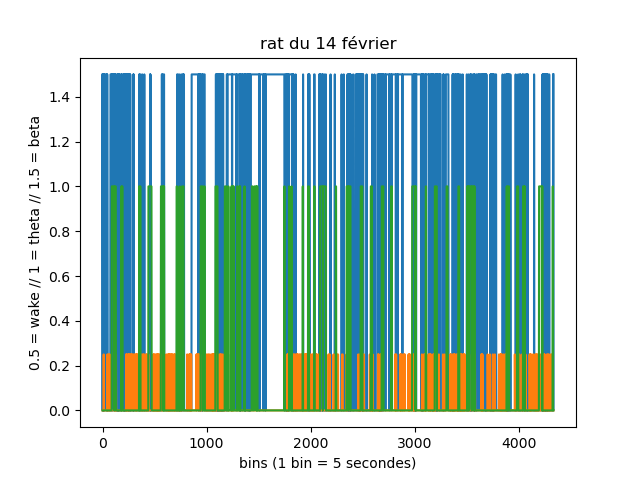

In [27]:
dwnsmpl_arrT = dwnsmpl_arrT * 1
dwnsmpl_arrW = dwnsmpl_arrW * 1.5
dwnsmpl_arr1B = dwnsmpl_arr1B * 0.5

plt.close()
plt.plot(dwnsmpl_arrW) #bleu
plt.plot(dwnsmpl_arr1B) #orange
plt.plot(dwnsmpl_arrT) # vert
plt.title('rat du 14 février')
plt.xlabel('bins (1 bin = 5 secondes)')
plt.ylabel('0.5 = wake // 1 = theta // 1.5 = beta')
plt.show()

4329


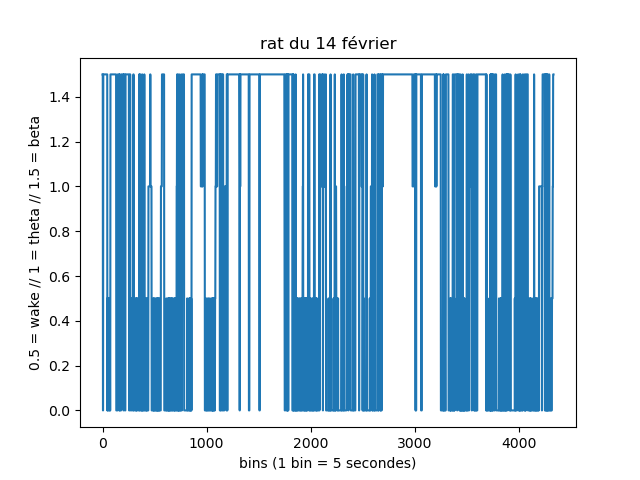

In [34]:
ScoringVectorS = np.zeros((len(dwnsmpl_arrW)))
for ind in range(len(dwnsmpl_arrW)):
    if dwnsmpl_arr1B[ind]>0:
        ScoringVectorS[ind] = 0.5
    if dwnsmpl_arrT[ind]>0:
        ScoringVectorS[ind] = 1
    if dwnsmpl_arrW[ind]>0:
        ScoringVectorS[ind] = 1.5



for i in range(len(ScoringVectorS)):
    if i > (len(ScoringVectorS)-4):
        print(i)
        break          
    elif (ScoringVectorS[i]==0.5 and ScoringVectorS[i+1]==0 and ScoringVectorS[i+2]>0):
        ScoringVectorS[i+1]=0.5
    elif (ScoringVectorS[i]==1 and ScoringVectorS[i+1]==0 and ScoringVectorS[i+2]>0):
        ScoringVectorS[i+1]=1
    elif (ScoringVectorS[i]==1.5 and ScoringVectorS[i+1]<1.5 and (ScoringVectorS[i+2]==1.5 or ScoringVectorS[i+3]==1.5)):
        ScoringVectorS[i+1]=1.5

plt.close()
plt.plot(ScoringVectorS)
plt.title('rat du 14 février')
plt.xlabel('bins (1 bin = 5 secondes)')
plt.ylabel('0.5 = wake // 1 = theta // 1.5 = beta')
plt.show()

In [ ]:
filenameOut = folder_base / f'ScoredSleep.npy'
np.save(filenameOut, ScoringVectorS)



No such comm: aed0ff7316b844a1be469f234287155b


No such comm: 2a74f7d8403f4c44bb0dcd1e4b39b027


Durée totale de l'éveil : 9710.0 secondes
Durée totale du theta : 1795.0 secondes
Durée totale du beta : 1470.0 secondes
Durée totale des transitions wake_theta : 120.0 secondes
Durée totale des transitions theta_beta : 5.0 secondes
Durée totale des transitions beta_theta : 50.0 secondes
Durée totale des transitions theta_wake : 205.0 secondes
Durée totale des transitions wake_beta : 0.0 secondes
Durée totale des transitions beta_wake : 65.0 secondes
Durée totale : 13420.0 secondes


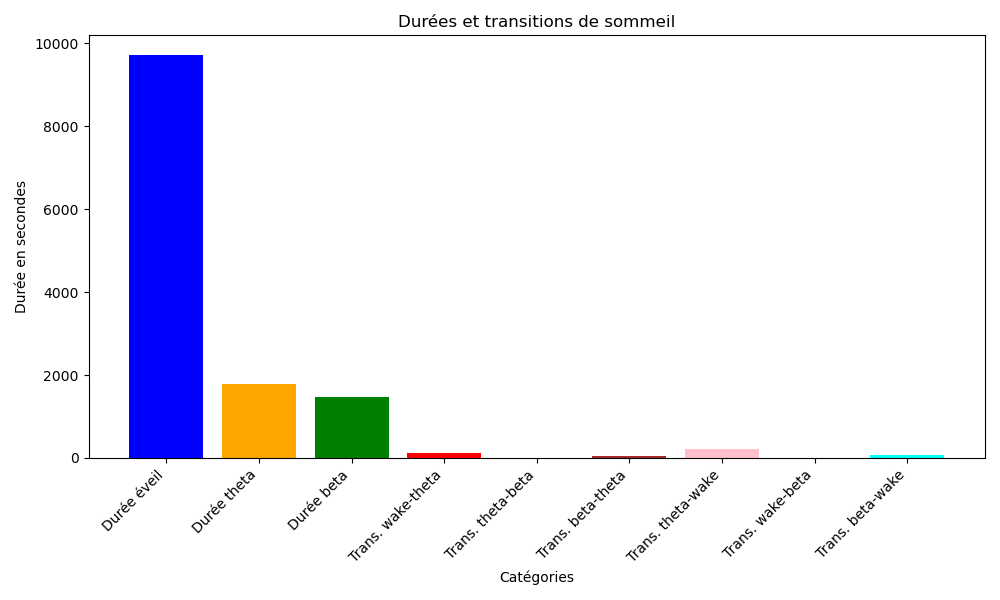

In [35]:
# Charger le score de sommeil
filenameOut = folder_base / 'ScoredSleep.npy'
scored_sleep = np.load(filenameOut)

# Compter les états
total_wake = np.sum(scored_sleep == 1.5)
total_theta= np.sum(scored_sleep == 1)
total_beta = np.sum(scored_sleep == 0.5)
total_transition_wake_theta = np.sum((scored_sleep[:-1] == 1.5) & (scored_sleep[1:] == 1))  # Transition de l'éveil au sommeil
total_transition_theta_beta = np.sum((scored_sleep[:-1] == 1) & (scored_sleep[1:] == 0.5))  # Transition de l'éveil au sommeil
total_transition_beta_theta = np.sum((scored_sleep[:-1] == 0.5) & (scored_sleep[1:] == 1))  # Transition de l'éveil au sommeil
total_transition_theta_wake = np.sum((scored_sleep[:-1] == 1) & (scored_sleep[1:] == 1.5))  # Transition de l'éveil au sommeil
total_transition_wake_beta = np.sum((scored_sleep[:-1] == 1.5) & (scored_sleep[1:] == 0.5))  # Transition du sommeil à l'éveil
total_transition_beta_wake = np.sum((scored_sleep[:-1] == 0.5) & (scored_sleep[1:] == 1.5))  # Transition de l'éveil au sommeil

# Calculer les durées en secondes (en supposant un échantillonnage à 1 Hz)
sampling_rate = 0.2 # Hz 1 bin = 5 secondes // 
duration_wake = total_wake / sampling_rate
duration_theta = total_theta / sampling_rate
duration_beta = total_beta / sampling_rate
duration_transition_wake_theta = total_transition_wake_theta / sampling_rate
duration_transition_theta_beta = total_transition_theta_beta / sampling_rate
duration_transition_beta_theta = total_transition_beta_theta / sampling_rate
duration_transition_theta_wake = total_transition_theta_wake / sampling_rate
duration_transition_wake_beta = total_transition_wake_beta / sampling_rate
duration_transition_beta_wake = total_transition_beta_wake / sampling_rate
total_duration = duration_wake + duration_theta + duration_beta + duration_transition_wake_theta + duration_transition_theta_beta + duration_transition_beta_theta + duration_transition_theta_wake + duration_transition_wake_beta + duration_transition_beta_wake

print("Durée totale de l'éveil :", duration_wake, "secondes")
print("Durée totale du theta :", duration_theta, "secondes")
print("Durée totale du beta :", duration_beta, "secondes")
print("Durée totale des transitions wake_theta :", duration_transition_wake_theta, "secondes")
print("Durée totale des transitions theta_beta :", duration_transition_theta_beta, "secondes")
print("Durée totale des transitions beta_theta :", duration_transition_beta_theta, "secondes")
print("Durée totale des transitions theta_wake :", duration_transition_theta_wake, "secondes")
print("Durée totale des transitions wake_beta :", duration_transition_wake_beta, "secondes")
print("Durée totale des transitions beta_wake :", duration_transition_beta_wake, "secondes")
print("Durée totale :", total_duration, "secondes")

# Durées et transitions
labels = ['Durée éveil', 'Durée theta', 'Durée beta', 'Trans. wake-theta', 'Trans. theta-beta', 'Trans. beta-theta', 'Trans. theta-wake', 'Trans. wake-beta', 'Trans. beta-wake']
durations = [duration_wake, duration_theta, duration_beta, duration_transition_wake_theta, duration_transition_theta_beta, duration_transition_beta_theta, duration_transition_theta_wake, duration_transition_wake_beta, duration_transition_beta_wake]

# Création du graphe
plt.figure(figsize=(10, 6))
plt.bar(labels, durations, color=['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'cyan'])
plt.xlabel('Catégories')
plt.ylabel('Durée en secondes')
plt.title('Durées et transitions de sommeil')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Affichage du graphe
plt.show()